In [1]:
%matplotlib widget 
# Uncomment for interactive plots when running the notebook!

import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

import import_ipynb

import PyPO
from PyPO.System import System
from PyPO.Enums import Projections, Units, Objects

In [2]:
# This code allows us to display global variables within markdown output, by overriding the %%markdown magic
from IPython.display import Markdown
from IPython.core.magic import register_cell_magic

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))

In [3]:
# Create the optical system
s = System()

2026-02-12 13:03:34 - WARNING - System override set to True. 


# Import SMA antenna parameters

We import the SMA antenna parameters from the `./design/sma_antenna_design.ipynb` notebook

In [4]:
# SMA antenna parameters

# Primary reflector
from design.sma_antenna_design import D_p, F_p, D_s, c_s, a_s, e_s, z_sh, f_s2

# Calculate distance from secondary edge plane to Cass focus
z_sef2 = f_s2 + z_sh

Primary Focal Length (F_p) : 2.520 m
Primary Rim Height (h_p): 0.893 m
Angle of edge ray (alpha) :61.52543906847784°
Vertical distance from prime focus to secondary edge plane (z_sedge1): 0.094917 m
Distance from prime focus to secondary edge plane (r_sedge1): 0.094916667 m
Angle of edge ray from Cassegrain focus to secondary edge (thetae) 2.0462388063868757°
Distance from Cassegrain focus to secondary edge (r_sedge2) 4.901135272577161 m
Subreflector eccentricity (e_s): 1.0618612323260763

Subreflector conic constant (k): -1.1275492767170534
Subreflector distance to vertex (a_s) : 2.351025969621911 m
Subreflector distance to focus (c_s): 2.496463333333331 m
Subreflector distance between foci (2 c_s) : 4.992926666666662 m
Ratio between distance between foci and Primary focal length (2 c_s/F_p) : 1.981320105820104
Subreflector (b_s) : 0.8396463927398957 m

Subreflector radius of curvature on axis (R_s): 0.28240193053417684 m
Subreflector input focal distance (f_s1) : 0.1454373637114199 m

In [5]:
%%markdown 
## Imported Antenna parameters

| Parameter | Variable | Value | Unit |
| --- | --- | --: | --- |
| Primary Diameter | `D_p` | {D_p:.3f} | m |
| Primary Focal Length | `F_p` | {F_p:.3f} | m |
| Secondary Diameter | `D_s` | {D_s:.3f} | m | 
| Secondary Distance to Foci | `c_s` | {c_s:.6f} | m |
| Secondary Distance to Vertex | `a_s` | {a_s:.6f} | m |
| Secondary Eccentricity | `e_s` | {e_s:.6f} |   |
| Height of Secondary | `z_sh` | {z_sh:.6f} | m |
| Distance from Secondary to Focus | `z_sef2` | {z_sef2:.6f} | m |

## Imported Antenna parameters

| Parameter | Variable | Value | Unit |
| --- | --- | --: | --- |
| Primary Diameter | `D_p` | 6.000 | m |
| Primary Focal Length | `F_p` | 2.520 | m |
| Secondary Diameter | `D_s` | 0.350 | m | 
| Secondary Distance to Foci | `c_s` | 2.496463 | m |
| Secondary Distance to Vertex | `a_s` | 2.351026 | m |
| Secondary Eccentricity | `e_s` | 1.061861 |   |
| Height of Secondary | `z_sh` | 0.050521 | m |
| Distance from Secondary to Focus | `z_sef2` | 4.898010 | m |


# Define the reflectors

In [ ]:
secondary = {
            "name"      : "secondary",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "flip"      : True,
            "focus_1"   : np.array([0, 0, F_p])*Units.M,
            "focus_2"   : np.array([0, 0, F_p - 2*c_s])*Units.M,
            "ecc"       : e_s,
            "lims_u"    : np.array([0, D_s/2])*Units.M,
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([351, 720])
            }

s.addHyperbola(secondary)

primary = {
            "name"      : "primary",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "vertex"    : np.zeros(3),
            "focus_1"   : np.array([0, 0, F_p])*Units.M,
            "lims_u"    : np.array([D_s/2, D_p/2])*Units.M,
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([301, 720])
            }

s.addParabola(primary)

2026-02-13 09:12:13 - INFO - Added paraboloid primary to system. 
2026-02-13 09:12:13 - INFO - Added hyperboloid secondary to system. 


# Define the output field planes

In [256]:
primary_focus_plane = {
            "name"      : "primary_focus_plane",
            "gmode"     : "xy",
            "lims_x"    : np.array([-1, 1]),
            "lims_y"    : np.array([-1, 1]),
            "gridsize"  : np.array([101, 101])
            }
s.addPlane(primary_focus_plane)
s.translateGrids("primary_focus_plane", np.array([0, 0, F_p])*Units.M)

primary_aperture_plane = {
            "name"      : "primary_aperture_plane",
            "gmode"     : "uv",
            "lims_u"    : np.array([0, 3]),
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([301, 360])
            }
s.addPlane(primary_aperture_plane)
s.translateGrids("primary_aperture_plane", np.array([0, 0, F_p])*Units.M)


farfield_plane = {
            "name"      : "farfield_plane",
            "gmode"     : "AoE",
            "lims_Az"    : np.array([-1.0, 1.0])*2e-1,
            "lims_El"    : np.array([-1.0, 1.0])*2e-1,
            "gridsize"  : np.array([301, 301])
            }
s.addPlane(farfield_plane)

2026-02-13 09:12:14 - INFO - Added plane primary_focus_plane to system. 
2026-02-13 09:12:14 - INFO - Translated element primary_focus_plane by ('0.000e+00', '0.000e+00', '2.520e+03') millimeters. 
2026-02-13 09:12:14 - INFO - Added plane primary_aperture_plane to system. 
2026-02-13 09:12:14 - INFO - Translated element primary_aperture_plane by ('0.000e+00', '0.000e+00', '2.520e+03') millimeters. 
2026-02-13 09:12:14 - INFO - Added plane farfield_plane to system. 


# Define a Gaussian feed

We initially define a Gaussian feed at the Cassegrain focus, with an -12 dB edge taper at the plane of the secondary edge, as a basic example of a Cassegrain antenna calculation

In [257]:
# Wavelength in millimeters
lam = 1.3

# Gaussian feed parameters
edge_taper_db = -12.0 # Gaussian edge taper

# beam width at secondary
beamwidth_s = D_s / 2 / ( 0.3393 * np.sqrt(-edge_taper_db))*1e3

# Calculate beam width at Cassegrain focus using Gaussian beam propagation
beamwidth_cass = beamwidth_s * np.sqrt((1 - np.sqrt(1 - (2*lam*(z_sef2*1e3) / (np.pi*beamwidth_s**2))**2 ) )/2)
w_0 = beamwidth_cass

# Rayleigh range
rayleigh_range = np.pi*w_0**2 / lam
z_R = rayleigh_range

In [258]:
%%markdown

## Gaussian feed parameters

| Parameter | Variable | Value | Unit |
| --- | --- | --: | --- |
| Wavelength | `lam` | {lam:.3f} | mm |
| Beam waist | `w_0` | {w_0:.3f} | mm |
| Rayleigh range | `z_R` | {z_R:.3f} | mm |


## Gaussian feed parameters

| Parameter | Variable | Value | Unit |
| --- | --- | --: | --- |
| Wavelength | `lam` | 1.300 | mm |
| Beam waist | `w_0` | 13.671 | mm |
| Rayleigh range | `z_R` | 451.630 | mm |


In [387]:
# The feed plane defines the source fields - it needs sufficient size and resolution to
# contain the feed.
feed_plane = {
            "name"      : "feed_plane",
            "gmode"     : "xy",
            "lims_x"    : np.array([-w_0*10, w_0*10]),
            "lims_y"    : np.array([-w_0*10, w_0*10]),
            "gridsize"  : np.array([401, 401])
            }

s.addPlane(feed_plane)

2026-02-13 10:14:33 - INFO - Added plane feed_plane to system. 


In [388]:
# Create a Gaussian field in the feed plane

feed_dict = {                                                                                                                                                                     
            "name"      : "gaussian_feed",                                                                                                                                  
            "lam"       : lam,                                                                                                      
            "w0x"       : w_0,                                                                                             
            "w0y"       : w_0,                                                                                             
            "n"         : 1,                                                                                                                             
            "E0"        : 1,                                                                                                                                  
            "dxyz"      : 0,                                                                                                 
            "pol"       : np.array([1, 0, 0])                                                                                                          
}

s.createGaussian(feed_dict, "feed_plane")

# Move the feed plane to the Cassegrain focus
s.translateGrids("feed_plane", np.array([0, 0, F_p - 2*c_s])*Units.M)

2026-02-13 10:14:34 - INFO - Translated element feed_plane by ('0.000e+00', '0.000e+00', '-2.473e+03') millimeters. 


# Check the system

We plot the system to check that everything looks right

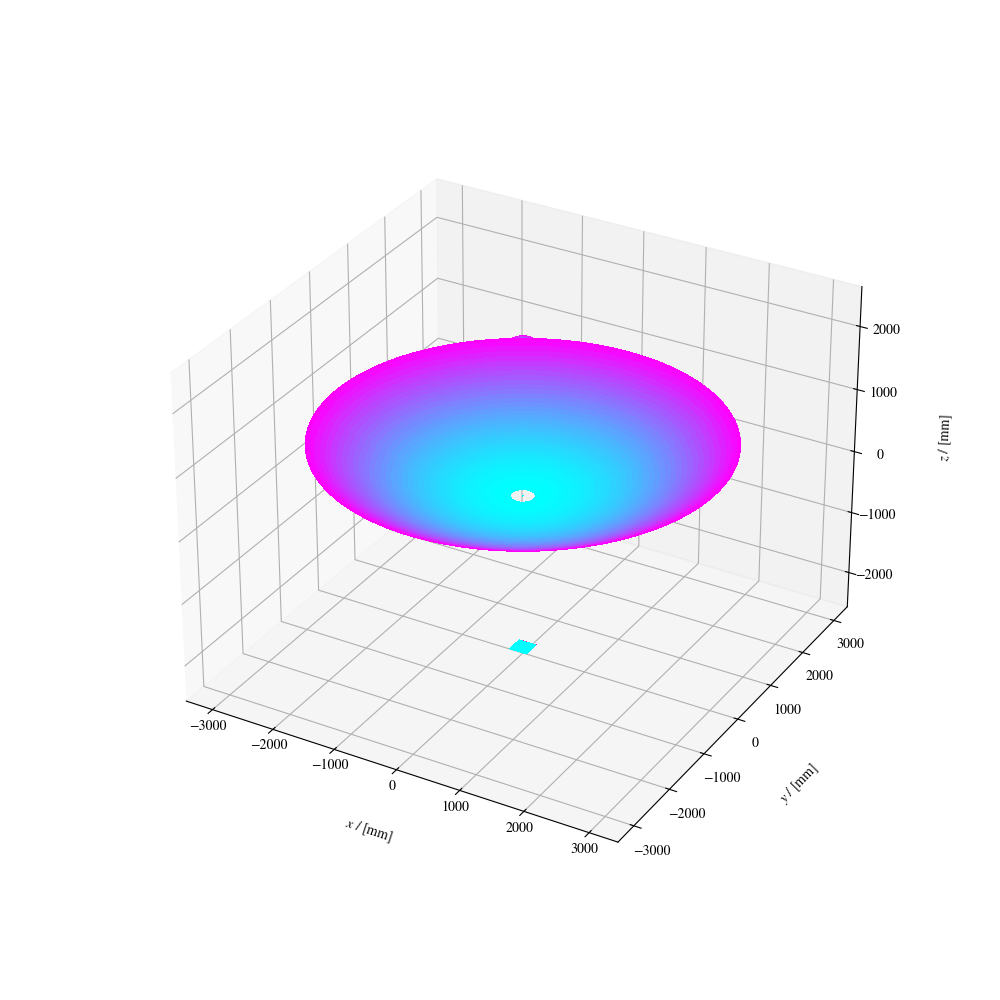

In [389]:
s.plotSystem()

# Set up the Physical Optics Calculations

We now setup the physical optics calculations through the system.

The `method` can be either `CPU` or `GPU` to choose between the C and CUDA implementations. This change also affects the
the floating point precision used in the calculations.

The `mode` for intermediate surfaces can be either `JMEH` or `JM`. In the `JMEH`, both the E & H fields and the J & M 
currents are calculated and stored on each surface.  In the `JM` mode, only the currents are stored. Choosing the `JM` mode
is somewhat faster, and uses less RAM.

In [400]:
method = 'GPU'
if method == 'CPU':
    nThreads = 24
else:
    nThreads = 256
mode = 'JMEH'

In [401]:
# Physical optics calculation definition from feed to secondary
feed_to_sec_PO = {
        "t_name"    : "secondary",
        "s_current" : "gaussian_feed",
        "epsilon"   : 100,
        "mode"      : mode,
        "name_JM"   : "JM_sec",
        "name_EH"   : "EH_sec",
        "device"    : method,
        "nThreads"  : nThreads
        }

# Physical optics calculation definition from secondary to primary
sec_to_pri_PO = {
        "t_name"    : "primary",
        "s_current" : "JM_sec",
        "epsilon"   : 100,
        "mode"      : mode,
        "name_JM"   : "JM_pri",
        "name_EH"   : "EH_pri",
        "device"    : method,
        "nThreads"  : nThreads
        }

# Physical optics calculation definition from primary to far field
pri_to_ff_PO = {
        "t_name"    : "farfield_plane",
        "s_current" : "JM_pri",
        "epsilon"   : 10,
        "mode"      : "FF",
        "name_EH"   : "EH_ff",
        "device"    : method,
        "nThreads"  : nThreads
        }

# Physical optics calculation definition from primary to far field
pri_to_apert_PO = {
        "t_name"    : "primary_aperture_plane",
        "s_current" : "JM_pri",
        "epsilon"   : 10,
        "mode"      : "EH",
        "name_EH"   : "EH_aperture",
        "device"    : method,
        "nThreads"  : nThreads
        }

# Run the Physical Optics calculations

We run the full Physical Optics calculations, and collect some perfomance information on the way

In [402]:
start = perf_counter()
step_times = []

s.runPO(feed_to_sec_PO)
step_times.append(perf_counter() - start)

#s.runPO(sec_to_pri_PO)
#step_times.append(perf_counter() - step_times[-1] - start)

#s.runPO(pri_to_ff_PO)
#step_times.append(perf_counter() - step_times[-1]- start )

#s.runPO(pri_to_apert_PO)
#step_times.append(perf_counter() - step_times[-1]- start )

2026-02-13 10:32:18 - WORK - *** Starting PO propagation *** 
2026-02-13 10:32:18 - WORK - Propagating gaussian_feed on feed_plane to secondary, propagation mode: JMEH. 
2026-02-13 10:32:18 - WORK - Hardware: running 256 CUDA threads per block. 
2026-02-13 10:32:18 - WORK - ... Calculating ... 
2026-02-13 10:32:21 - WORK - *** Finished: 2.817 seconds *** 


In [403]:
print(step_times)

[2.822570199990878]


# Examine Output

We now look at the output from the simulation

# Surface Currents on Secondary

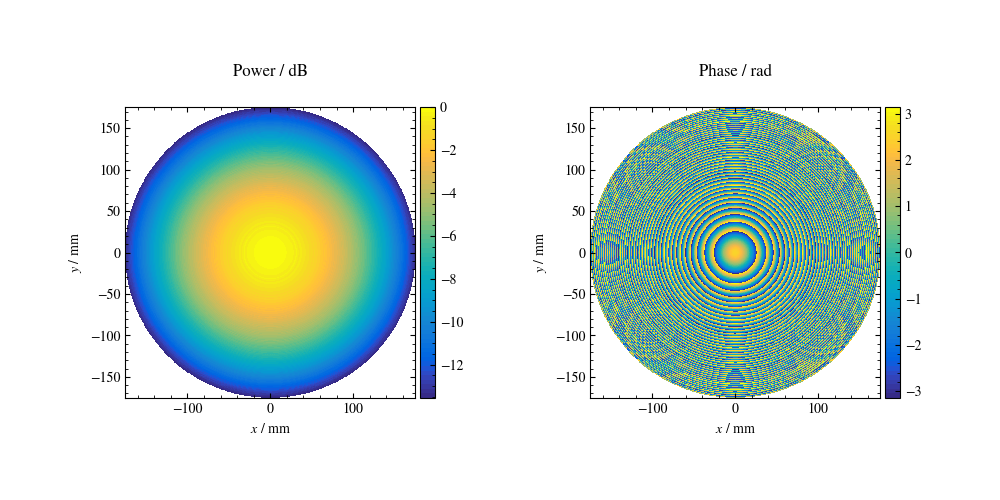

In [404]:
s.plotBeam2D('JM_sec', PyPO.Enums.CurrentComponents.Jx)

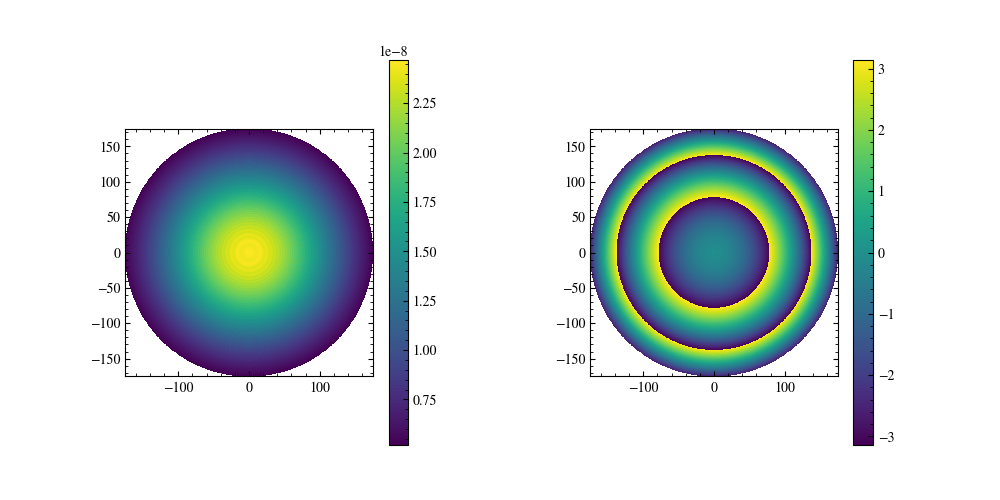

In [405]:
efield = s.currents['JM_sec'].Jx
grid = s.generateGrids('secondary')
x_grid = grid.x
y_grid = grid.y
z_grid = grid.z
phase_factor = np.exp(1j*2*np.pi/lam*z_grid)
#phase_factor = 1
fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'wspace':0.5})

ampfig = ax[0].pcolormesh(x_grid, y_grid, np.abs(efield))
phasefig = ax[1].pcolormesh(x_grid, y_grid, np.angle(efield*phase_factor), vmax=np.pi, vmin=-np.pi)

c1 = fig.colorbar(ampfig, orientation='vertical')
c2 = fig.colorbar(phasefig, orientation='vertical')

ax[0].set_aspect(1)
ax[1].set_aspect(1)

Text(0, 0.5, 'Phase (rad)')

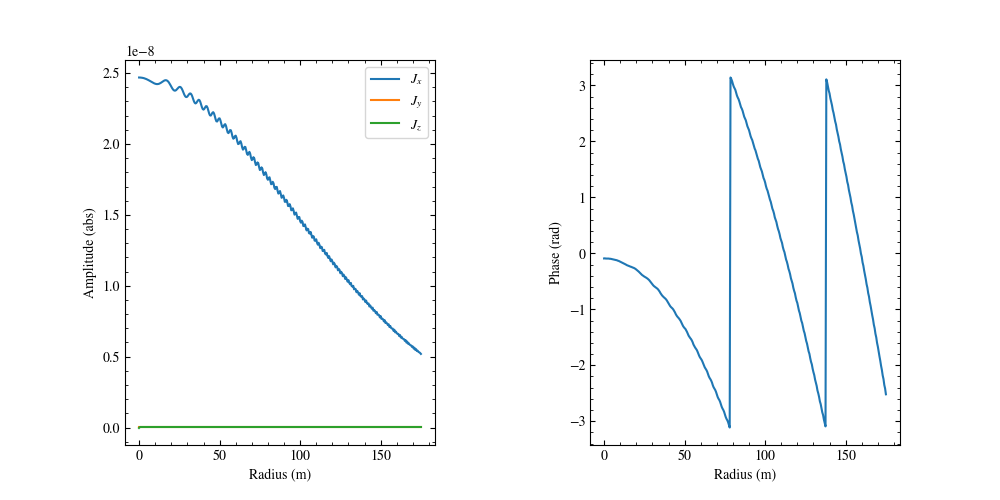

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'wspace':0.5})
ax[0].plot(grid.y[:,180], np.abs(s.currents['JM_sec'].Jx[:,180]), label='$J_x$')
ax[0].plot(grid.y[:,180], np.abs(s.currents['JM_sec'].Jy[:,180]), label='$J_y$')
ax[0].plot(grid.y[:,180], np.abs(s.currents['JM_sec'].Jz[:,180]), label='$J_z$')
ax[0].legend()
ax[0].set_xlabel('Radius (m)')
ax[0].set_ylabel('Amplitude (abs)')

ax[1].plot(grid.y[:,180], np.angle(s.currents['JM_sec'].Jx[:,180]*phase_factor[:,180]))
ax[1].set_xlabel('Radius (m)')
ax[1].set_ylabel('Phase (rad)')

## Incident H-field on Secondary

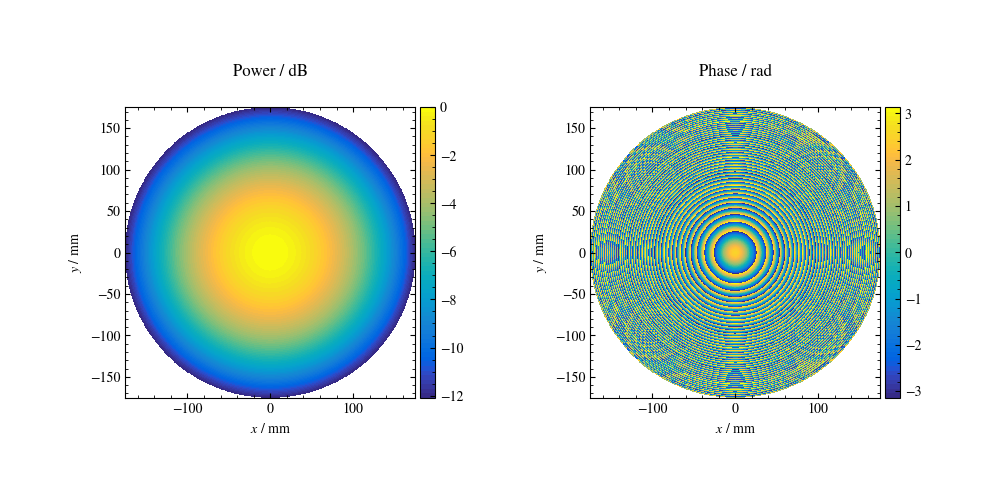

In [407]:
s.plotBeam2D('EH_sec', PyPO.Enums.FieldComponents.Hy)

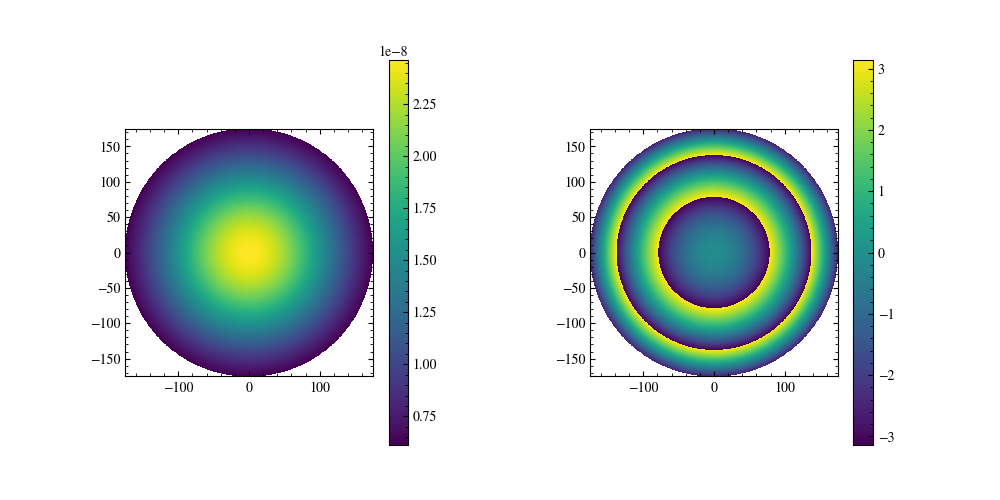

In [408]:
efield = s.fields['EH_sec'].Hy
grid = s.generateGrids('secondary')
x_grid = grid.x
y_grid = grid.y
z_grid = grid.z
phase_factor = np.exp(1j*2*np.pi/lam*z_grid)
#phase_factor = 1
fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'wspace':0.5})

ampfig = ax[0].pcolormesh(x_grid, y_grid, np.abs(efield))
phasefig = ax[1].pcolormesh(x_grid, y_grid, np.angle(efield*phase_factor), vmax=np.pi, vmin=-np.pi)

c1 = fig.colorbar(ampfig, orientation='vertical')
c2 = fig.colorbar(phasefig, orientation='vertical')

ax[0].set_aspect(1)
ax[1].set_aspect(1)

Text(0, 0.5, 'Phase (rad)')

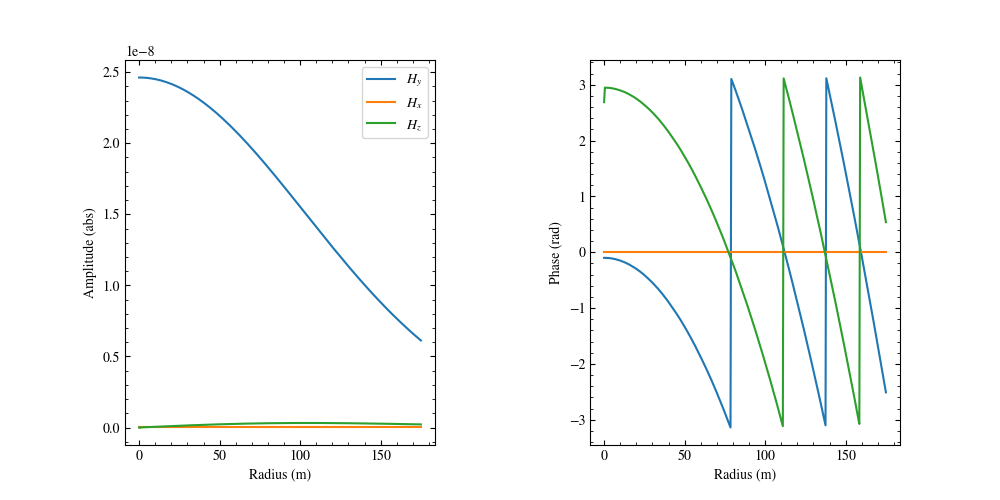

In [423]:
fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'wspace':0.5})
ax[0].plot(grid.y[:,180], np.abs(s.fields['EH_sec'].Hy[:,180]), label='$H_y$')
ax[0].plot(grid.y[:,180], np.abs(s.fields['EH_sec'].Hx[:,180]), label='$H_x$')
ax[0].plot(grid.y[:,180], np.abs(s.fields['EH_sec'].Hz[:,180]), label='$H_z$')
ax[0].legend()

ax[0].set_xlabel('Radius (m)')
ax[0].set_ylabel('Amplitude (abs)')

ax[1].plot(grid.y[:,180], np.angle(s.fields['EH_sec'].Hy[:,180]*phase_factor[:,180]), label='$H_y$')
ax[1].plot(grid.y[:,180], 0*np.angle(s.fields['EH_sec'].Hx[:,180]*phase_factor[:,180]), label='$H_x$')
ax[1].plot(grid.y[:,180], np.angle(s.fields['EH_sec'].Hz[:,180]*phase_factor[:,180]), label='$H_z$')

ax[1].set_xlabel('Radius (m)')
ax[1].set_ylabel('Phase (rad)')

Text(0, 0.5, 'Normal (a.u)')

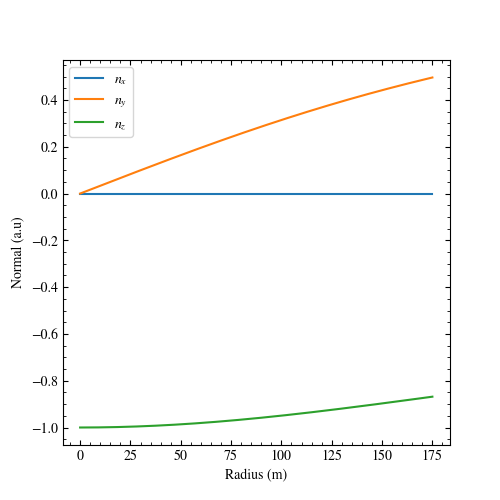

In [425]:
fig, ax = plt.subplots(1,1, figsize=(5,5), gridspec_kw={'wspace':0.5})
ax.plot(grid.y[:,180], grid.nx[:,180], label='$n_x$')
ax.plot(grid.y[:,180], grid.ny[:,180], label='$n_y$')
ax.plot(grid.y[:,180], grid.nz[:,180], label='$n_z$')
ax.legend()

ax.set_xlabel('Radius (m)')
ax.set_ylabel('Normal (a.u)')

# Surface Currents on Primary

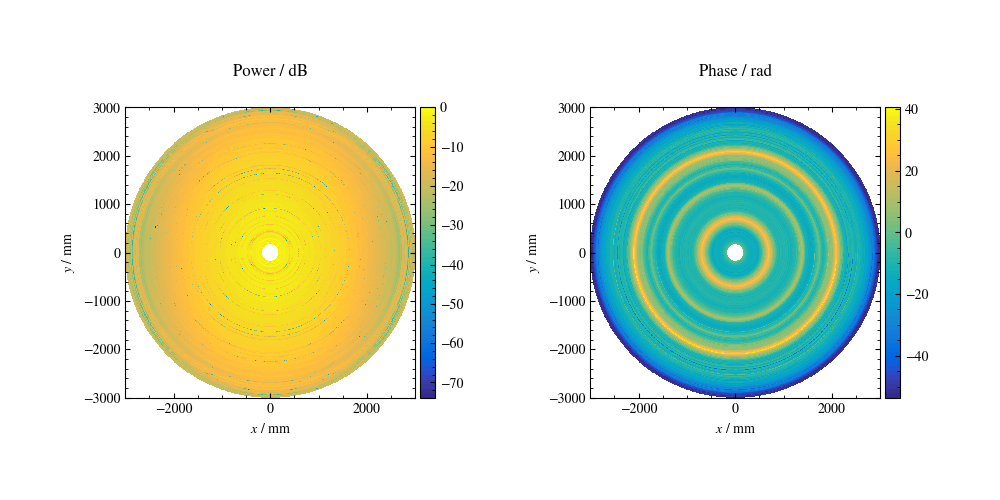

In [329]:
s.plotBeam2D('JM_pri', PyPO.Enums.CurrentComponents.Jx, unwrap_phase=True)

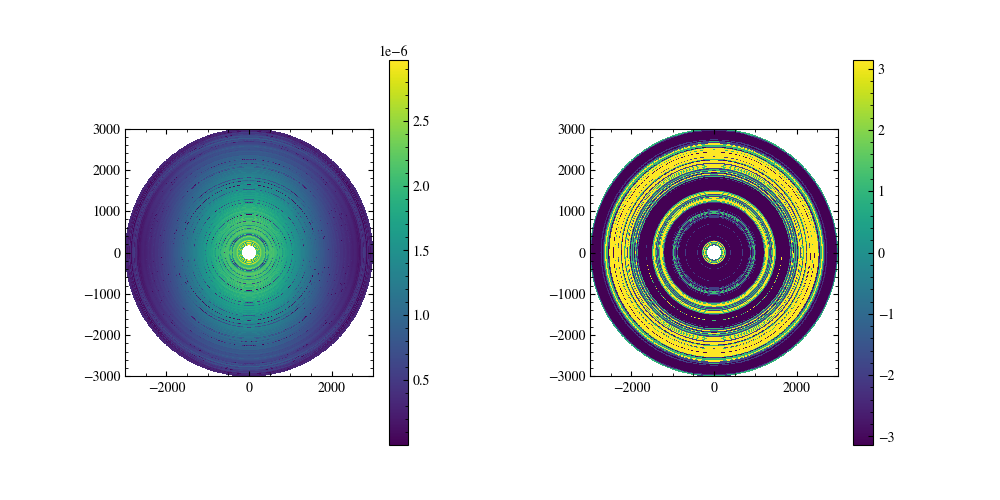

In [334]:
efield = s.currents['JM_pri'].Jx
grid = s.generateGrids('primary')
x_grid = grid.x
y_grid = grid.y
z_grid = grid.z
phase_factor = np.exp(-1j*2*np.pi/lam*z_grid)
#phase_factor = 1
fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'wspace':0.5})

ampfig = ax[0].pcolormesh(x_grid, y_grid, np.abs(efield))
phasefig = ax[1].pcolormesh(x_grid, y_grid, np.unwrap(np.unwrap(np.angle(efield*phase_factor), axis=0), axis=1), vmax=np.pi, vmin=-np.pi)

c1 = fig.colorbar(ampfig, orientation='vertical')
c2 = fig.colorbar(phasefig, orientation='vertical')

ax[0].set_aspect(1)
ax[1].set_aspect(1)

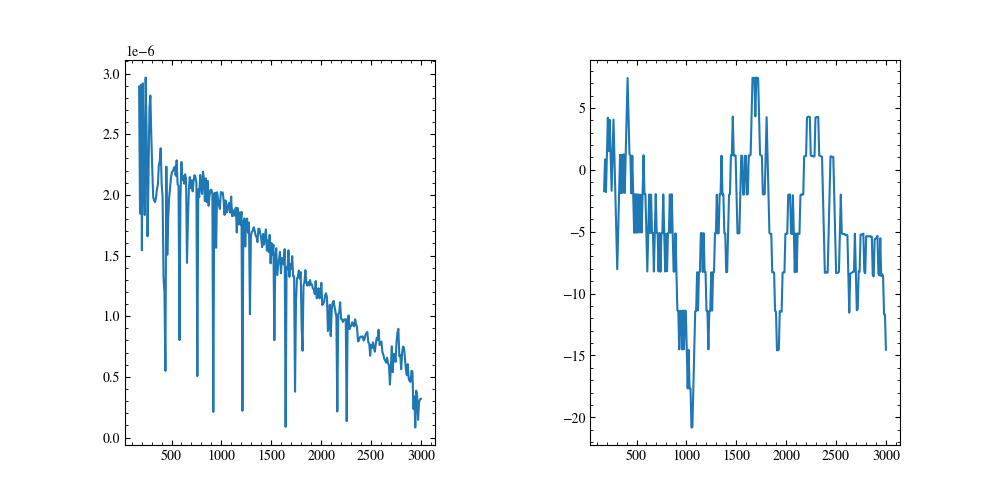

In [326]:
fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'wspace':0.5})
ax[0].plot(grid.y[:,180], np.abs(efield[:,180]))
ax[1].plot(grid.y[:,180], np.unwrap(np.angle(efield[:,180]*phase_factor[:,180])))

## Incident H-field on Primary

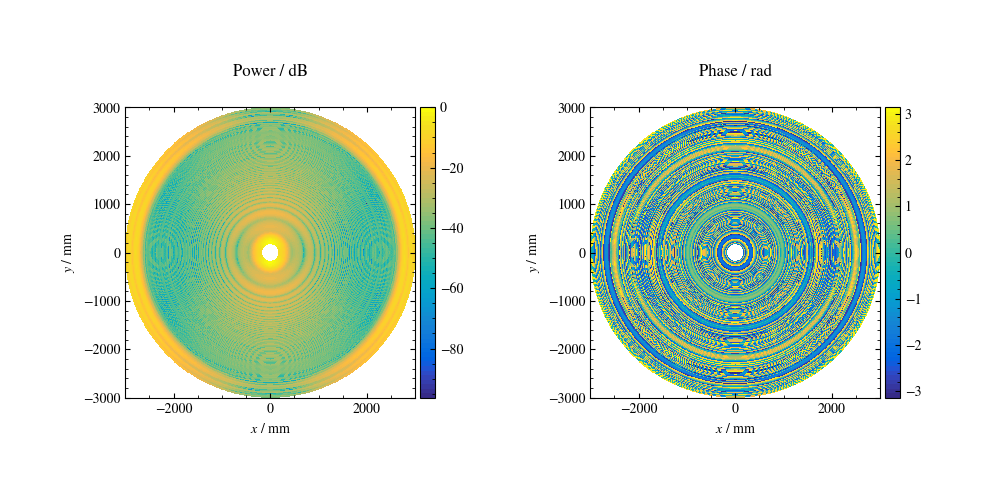

In [297]:
s.plotBeam2D('EH_pri', PyPO.Enums.FieldComponents.Hy, norm=False)

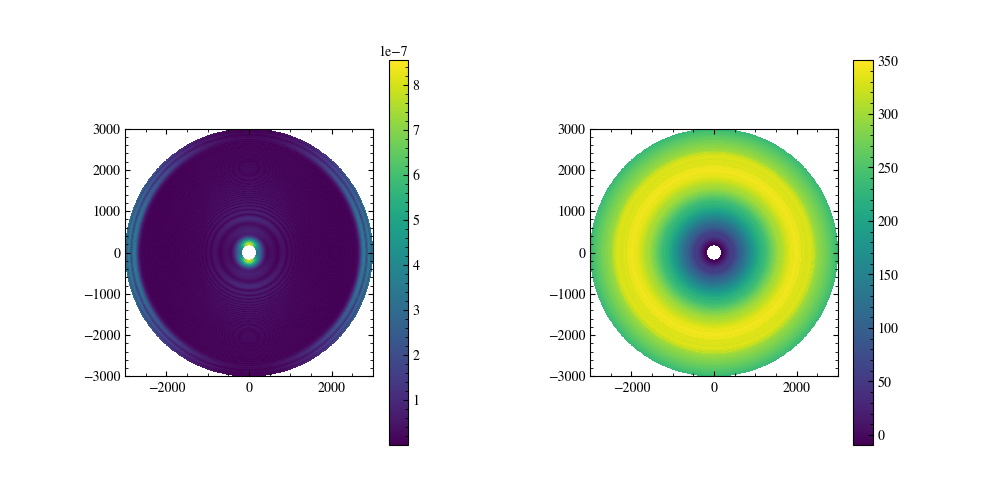

In [341]:
efield = s.fields['EH_pri'].Hy
grid = s.generateGrids('primary')
x_grid = grid.x
y_grid = grid.y
z_grid = grid.z
phase_factor = np.exp(1j*2*np.pi/lam*z_grid)
#phase_factor = 1
fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'wspace':0.5})

ampfig = ax[0].pcolormesh(x_grid, y_grid, np.abs(efield))
phasefig = ax[1].pcolormesh(x_grid, y_grid, np.unwrap(np.unwrap(np.angle(efield*phase_factor), axis=0), axis=1))

c1 = fig.colorbar(ampfig, orientation='vertical')
c2 = fig.colorbar(phasefig, orientation='vertical')

ax[0].set_aspect(1)
ax[1].set_aspect(1)

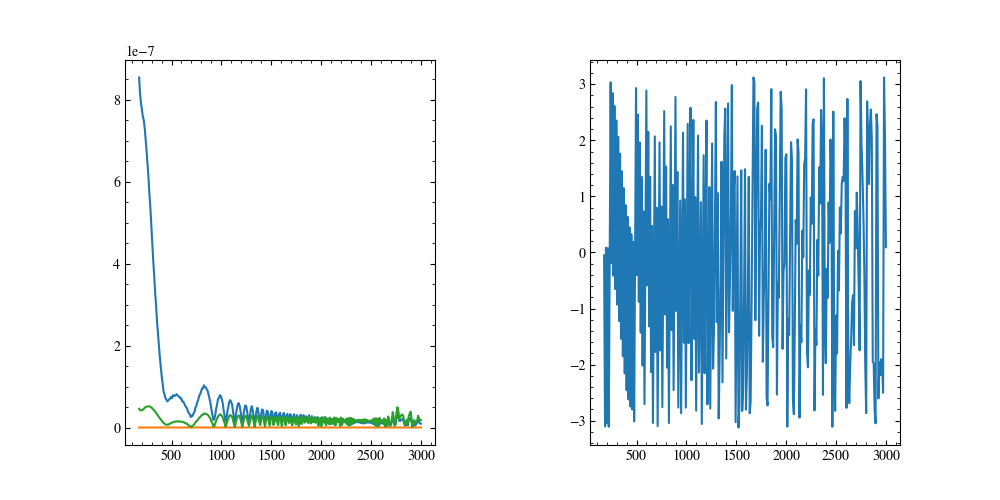

In [344]:
fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'wspace':0.5})
ax[0].plot(grid.y[:,180], np.abs(s.fields['EH_pri'].Hy[:,180]), label='$H_y$')
ax[0].plot(grid.y[:,180], np.abs(s.fields['EH_pri'].Hx[:,180]), label='$H_x$')
ax[0].plot(grid.y[:,180], np.abs(s.fields['EH_pri'].Hz[:,180]), label='$H_z$')
ax[1].plot(grid.y[:,180], np.angle(s.fields['EH_pri'].Hy[:,180]*phase_factor[:,180]))

Units.MM
mm


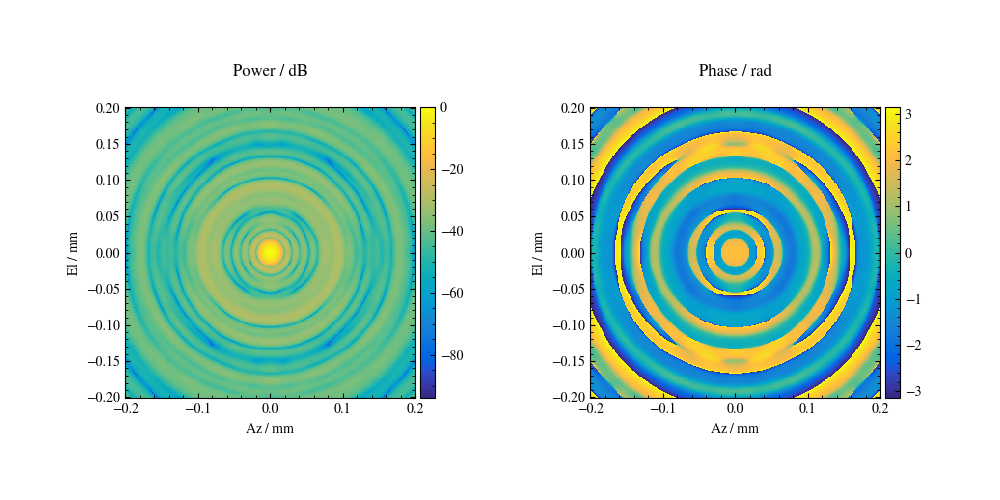

In [148]:
s.plotBeam2D('EH_ff', PyPO.Enums.FieldComponents.Ex)

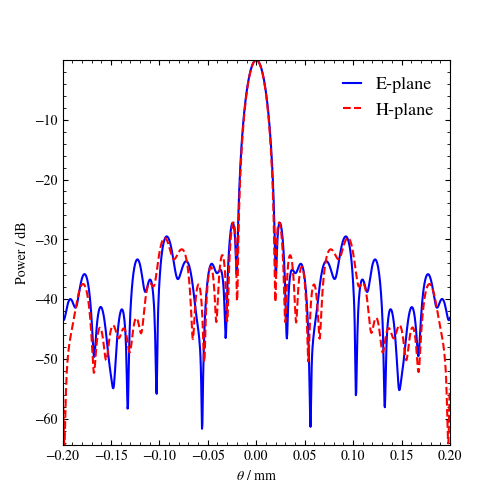

In [149]:
s.plotBeamCut('EH_ff', PyPO.Enums.FieldComponents.Ex)

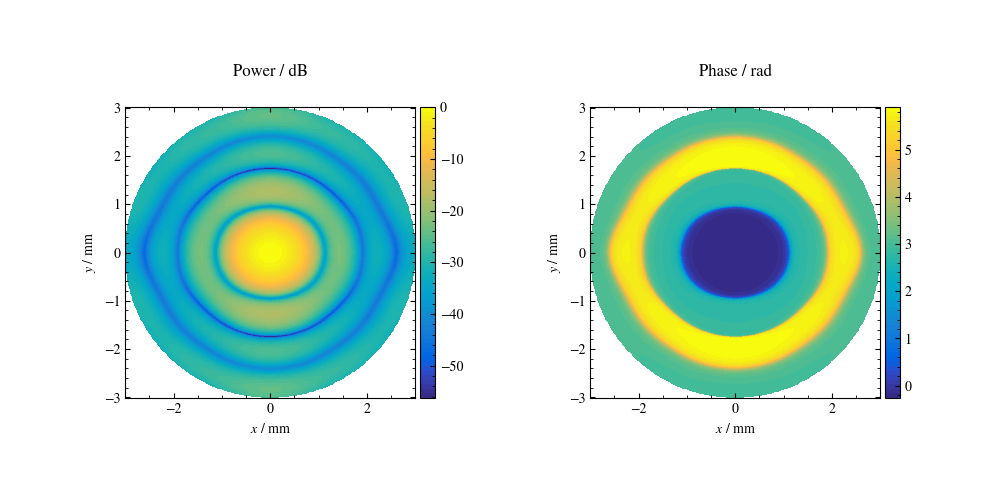

In [150]:
s.plotBeam2D('EH_aperture', PyPO.Enums.FieldComponents.Ex, unwrap_phase=True)

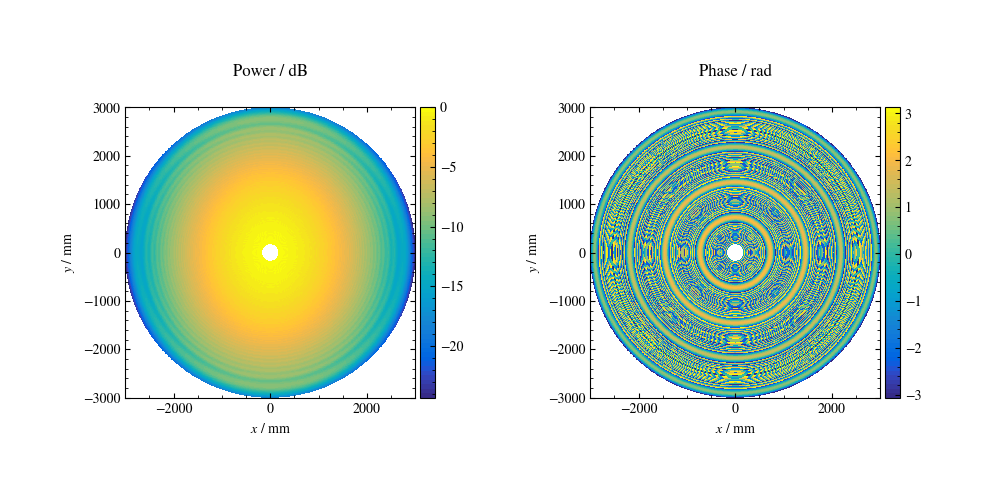

In [163]:
s.plotBeam2D('EH_pri', PyPO.Enums.FieldComponents.Ex)